**import**

In [1]:
# Import Moudles and Packages
import gc
import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import time
import random

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams["axes.grid"]=False

# Import pytorch modules
import torch
import torch.nn as nn
from torch.utils import data as D

from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
from torch.cuda.amp import autocast, GradScaler
from madgrad import MADGRAD

import natsort

import gc
import torch

from mpl_toolkits.axes_grid1 import ImageGrid
from torchsummary import summary
gc.collect()
torch.cuda.empty_cache()

device = 'cuda:1' if torch.cuda.is_available() else 'cpu'

print("__Import modules and packages__\n")
print("| Pytorch version: {}".format(torch.__version__))
print("| GPU: {}".format(torch.cuda.is_available()))
print("| Device : ",device)
print("| Device name: ", torch.cuda.get_device_name(0))
print("| Device count: ", torch.cuda.device_count())

__Import modules and packages__

| Pytorch version: 1.10.0+cu102
| GPU: True
| Device :  cuda:1
| Device name:  Tesla T4
| Device count:  4


**model**

In [2]:
import timm
model = timm.create_model("swin_base_patch4_window7_224", pretrained=True, num_classes=40)
model.eval()
model.load_state_dict(torch.load(
    f'/home/ubuntu/workspace/FLD-scratch/src/models/pretrained_model/0703/swin_lateral_home_200epoch_20pt.pth',
    map_location = 'cpu'))
model = model.to(device)

In [3]:
import src.dataset.kface_dataset_lateral_3ch as K_L
import src.dataset.kface_dataset_frontal_3ch as K_F
import src.dataset.kface_transform_A_plus as A

**dataset**

In [4]:
import src.config as C
k_dataset_train_lateral = K_L.kfacedataset(
    type="train",
    transform=A.get_augmentation(data_type="train")
    )

k_dataset_valid_lateral = K_L.kfacedataset(
    type="valid",
    transform=A.get_augmentation(data_type="valid")
    )

k_dataset_train_frontal = K_F.kfacedataset(
    type="train",
    transform=A.get_augmentation(data_type="train")
    )

k_dataset_valid_frontal = K_F.kfacedataset(
    type="valid",
    transform=A.get_augmentation(data_type="valid")
    )

k_dataset_train = k_dataset_train_frontal+k_dataset_train_lateral
k_dataset_valid = k_dataset_valid_frontal+k_dataset_valid_lateral

In [5]:
len_train = int(len(k_dataset_train)*0.8)
len_valid = len(k_dataset_train)-len_train

**dataloader**

In [6]:
train_dataset, _ = D.random_split(k_dataset_train, [len_train, len_valid])
_, valid_dataset = D.random_split(k_dataset_valid, [len_train, len_valid])

BATCH_SIZE = 32

train_loader = D.DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
valid_loader = D.DataLoader(
    valid_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

print(f'{len(train_dataset)} images for training')
print(f'{len(valid_dataset)} images for validating')

24895 images for training
6224 images for validating


**visualization**

torch.Size([3, 224, 224])


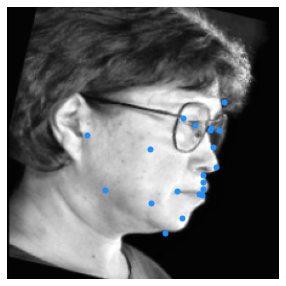

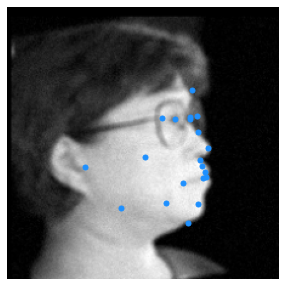

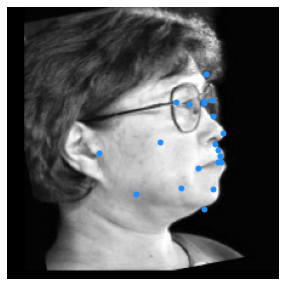

In [7]:
from src.utils.visualize import visualize_image, visualize_batch

image1, landmarks1 = train_dataset[0]
print(image1.shape)
visualize_image(image1, landmarks1)

image2, landmarks2 = train_dataset[0]
visualize_image(image2, landmarks2)

image3, landmarks3 = train_dataset[0]
visualize_image(image3, landmarks3)

In [8]:
for x, y in train_loader:
    break

print(x.shape, y.shape, x.max(), x.min(), y.max(), y.min())

for x, y in valid_loader:
    break

print(x.shape, y.shape, x.max(), x.min(), y.max(), y.min())

torch.Size([32, 3, 224, 224]) torch.Size([32, 40]) tensor(0.0086) tensor(-0.0082) tensor(0.5407) tensor(-0.4089)
torch.Size([32, 3, 224, 224]) torch.Size([32, 40]) tensor(0.0086) tensor(-0.0082) tensor(0.5216) tensor(-0.3240)


Training Batch Samples


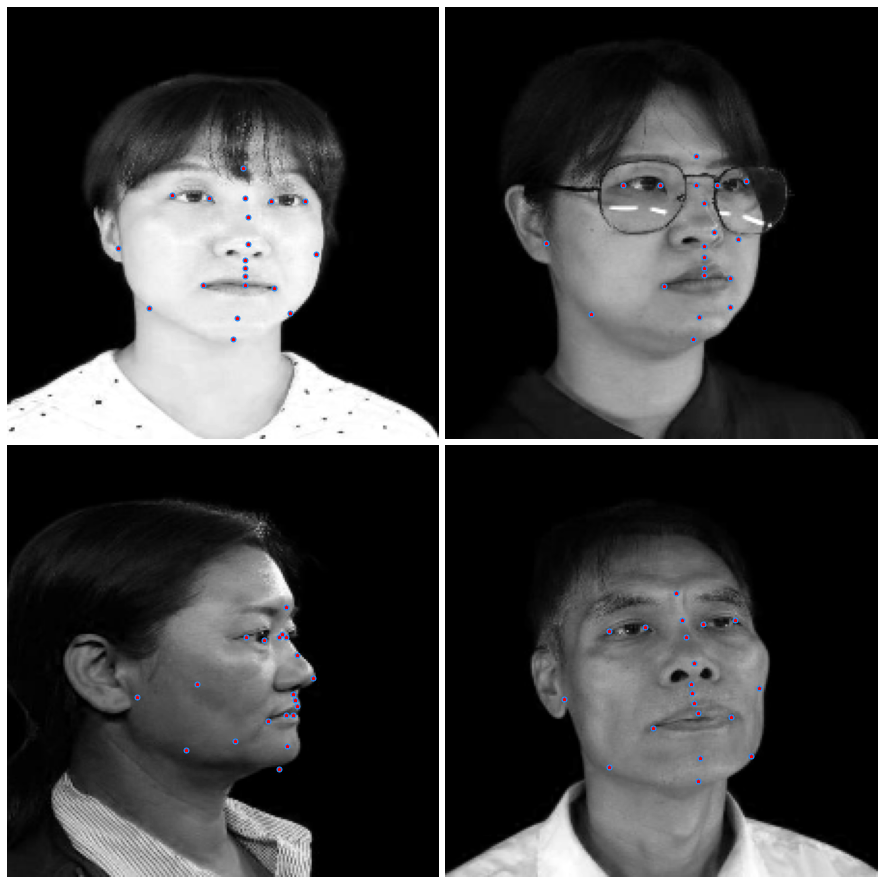

In [9]:
visualize_batch(x[:4], y[:4], y[:4], shape = (2, 2), size = 16, title = 'Training Batch Samples')

**Metric**

In [10]:
def accuracy(output, target, topk=(1,)):
    """Computes the precision@k for the specified values of k"""
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].view(-1).float().sum(0)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res

def normalizedME(output,target,w,h):
    batch_size = target.size(0)
    diff = output - target
    diff = np.sqrt(diff.T*diff)/(w*h)
    return diff/batch_size

**loss and optimizer**

In [11]:
import torch.optim as optim
objective = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr = 0.00002)

**define validation function**

In [38]:
def RMSE(true, pred):
    true = true.data.cpu().numpy()
    pred = pred.data.cpu().numpy()
    score = np.sqrt(np.mean(np.square(true-pred)))
    return score

Validation sample predictions


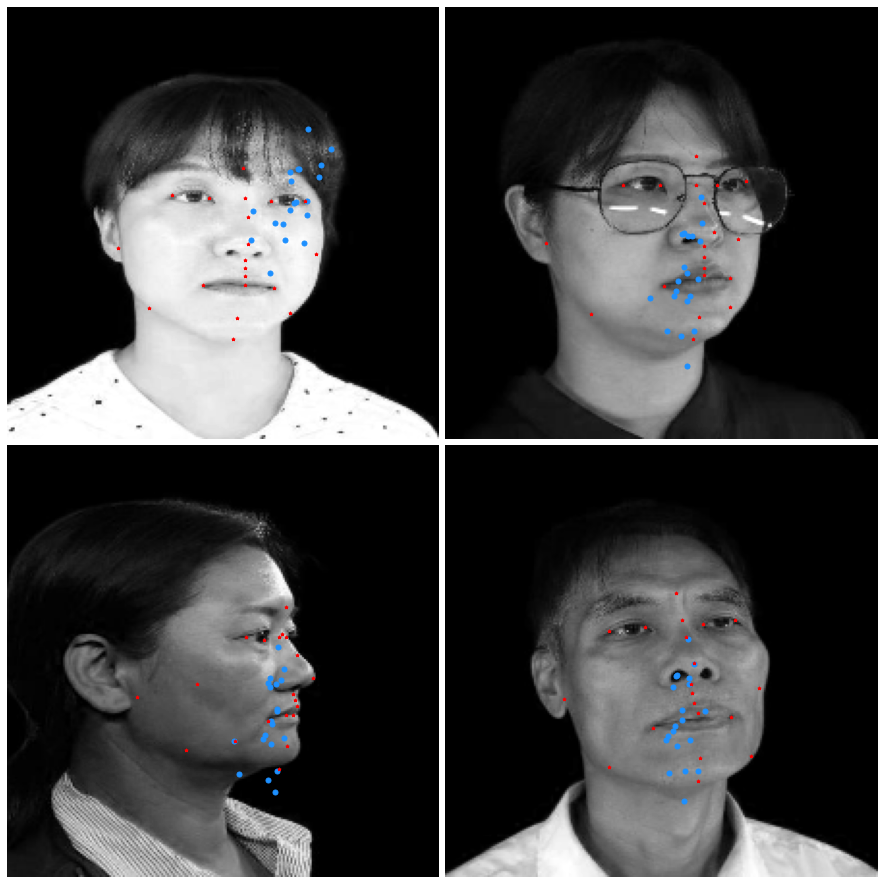

(6.660841500911957e-05, 0.0005844498291993753)

In [42]:
from tqdm import tqdm
from src.metric import nme
model.eval()
@torch.no_grad()
def validate(save = None):
    cum_loss = 0.0
    cum_rmse = 0.0
    for features, labels in valid_loader:
        features = features.to(device)
        labels = labels.to(device)
        
        with autocast(enabled=True):
            outputs = model(features)
            loss = objective(outputs, labels)
            rmse = RMSE(labels, outputs)
        
        cum_rmse += rmse
        cum_loss += loss.item()
        break
        
    visualize_batch(features[:4].cpu(), outputs[:4].cpu(), labels[:4].cpu(),
                    shape = (2, 2), size = 16, title = 'Validation sample predictions', save = save)

    return cum_loss/len(valid_loader), cum_rmse/len(valid_loader)

validate()

In [45]:
day = "0704"
type = "all_home_add_trans_noresize"
model_name = 'swin'
save_fig_path = f"logs/{day}/kface_progresses_{type}_{model_name}"

In [46]:
if not os.path.isdir(save_fig_path):
    os.makedirs(save_fig_path)    

In [47]:
epochs = 200
batches = len(train_loader)
best_loss = np.inf
optimizer.zero_grad()

start_time = time.time()
for epoch in range(epochs):
    cum_loss = 0.0
    scaler = GradScaler() 
    model.train()
    for idx, (features, labels) in enumerate(tqdm(train_loader, desc= 'Training')):
        features = features.to(device)
        labels = labels.to(device)

        with autocast(enabled=True):
            model = model.to(device)
            
            outputs = model(features)
        
            loss = objective(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
                
        optimizer.zero_grad()

        cum_loss += loss.item()
        
    val_loss, rsme = validate(os.path.join(f'/home/ubuntu/workspace/FLD-scratch/{save_fig_path}',
                                     f'epoch({str(epoch + 1).zfill(len(str(epochs)))}).jpg'))

    if val_loss < best_loss:
        best_loss = val_loss
        print('Saving model....................')
        save_model_path = f'/home/ubuntu/workspace/FLD-scratch/src/models/pretrained_model/{day}'
        os.makedirs(save_model_path)
        
        save_model = os.path.join(save_model_path,f"{model_name}_{type}_{epochs}epoch_20pt_add_trans_noresize.pth")
        torch.save(model.state_dict(), save_model)

    print(f'Epoch({epoch + 1}/{epochs}) -> Training Loss: {cum_loss/batches:.8f} | Validation Loss: {val_loss:.8f} | Validation Rsme: {rsme:.8f}')

print('Training Complete')
print("Total Elapsed Time : {} s".format(time.time()-start_time))    

Training:  11%|█         | 86/778 [00:49<06:35,  1.75it/s]